In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
products = pd.read_csv('./amazon_baby_subset.csv')
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [3]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

In [4]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [5]:
important_words = pd.read_json('./important_words.json', typ='list').tolist()

In [6]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

In [7]:
train_idx = pd.read_json('./module-4-assignment-train-idx.json', typ='list').tolist()
validation_idx = pd.read_json('./module-4-assignment-validation-idx.json', typ='list').tolist()

train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]

In [8]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/home/jue/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Build on logistic regression with no L2 penalty assignment

In [10]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1./(1. + np.exp(-score))
    
    # return predictions
    return predictions

# Adding L2 penalty

In [62]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = derivative - 2.*l2_penalty*coefficient
        
    return derivative

## Q1

In [63]:
print 'the code above does not regularize the intercept term'

the code above does not regularize the intercept term


In [64]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

## Q2

In [65]:
print 'The term with L2 regularization decrease ll(w)'

The term with L2 regularization decrease ll(w)


In [66]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Explore effects of L2 regularization

In [67]:
L2_penalty = [0, 4, 10, 1e2, 1e3, 1e5]
coefficients = []
initial_coefficients = np.zeros(feature_matrix_train.shape[1])
step_size = 5e-6
max_iter = 501

for l2 in L2_penalty:
    coefficients.append(logistic_regression_with_L2(feature_matrix_train, sentiment_train, initial_coefficients,
                                                   step_size, l2, max_iter))

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

# Compare coefficients

In [68]:
coefficients_0_penalty = list(coefficients[0][1:])
word_coeff_tuple = [(word, coef) for word, coef in zip(important_words, coefficients_0_penalty)]
word_coeff_tuple = sorted(word_coeff_tuple, key= lambda x:x[1], reverse=True)

## Q3

In [69]:
positive_words = [x[0] for x in word_coeff_tuple[0:10]]
positive_words

[u'love',
 u'loves',
 u'easy',
 u'perfect',
 u'great',
 u'happy',
 u'best',
 u'little',
 u'fits',
 u'well']

In [70]:
word_coeff_tuple = sorted(word_coeff_tuple, key= lambda x:x[1], reverse=False)
negative_words = [x[0] for x in word_coeff_tuple[0:10]]
negative_words

[u'disappointed',
 u'money',
 u'return',
 u'waste',
 u'returned',
 u'broke',
 u'work',
 u'thought',
 u'idea',
 u'cheap']

In [71]:
table = pd.DataFrame({'word':['intercept']+important_words})
def add_coeff_to_table(coeff, col_name):
    table[col_name] = coeff

In [72]:
add_coeff_to_table(coefficients[0], 'L2 = 0')
add_coeff_to_table(coefficients[1], 'L2 = 4')
add_coeff_to_table(coefficients[2], 'L2 = 10')
add_coeff_to_table(coefficients[3], 'L2 = 1e2')
add_coeff_to_table(coefficients[4], 'L2 = 1e3')
add_coeff_to_table(coefficients[5], 'L2 = 1e5')
table

,word,L2 = 0,L2 = 4,L2 = 10,L2 = 1e2,L2 = 1e3,L2 = 1e5
0,intercept,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941


In [73]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

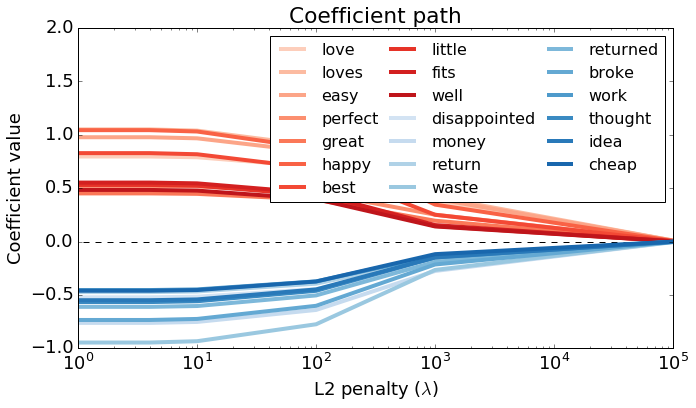

In [74]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

## Q4 & Q5

In [75]:
print 'yes, all coeffs consistently get smaller in size as l2 penalty increases'
print 'yes, the relative order of coeffs is preserved'

yes, all coeffs consistently get smaller in size as l2 penalty increases
yes, the relative order of coeffs is preserved


# Measuring accuracy

In [77]:
def predict_sentiment(feature_matrix, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    scores[scores >= 0] = +1
    scores[scores <0] = -1
    return scores

In [83]:
train_accuracy_0 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[0]))]
train_accuracy_0 = sum(train_accuracy_0)
print 'training accuracy with l2 penalty = 0 is ' + str(1.0*train_accuracy_0/len(sentiment_train))

train_accuracy_4 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[1]))]
train_accuracy_4 = sum(train_accuracy_4)
print 'training accuracy with l2 penalty = 4 is ' + str(1.0*train_accuracy_4/len(sentiment_train))

train_accuracy_10 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[2]))]
train_accuracy_10 = sum(train_accuracy_10)
print 'training accuracy with l2 penalty = 10 is ' + str(1.0*train_accuracy_10/len(sentiment_train))

train_accuracy_1e2 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[3]))]
train_accuracy_1e2 = sum(train_accuracy_1e2)
print 'training accuracy with l2 penalty = 1e2 is ' + str(1.0*train_accuracy_1e2/len(sentiment_train))

train_accuracy_1e3 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[4]))]
train_accuracy_1e3 = sum(train_accuracy_1e3)
print 'training accuracy with l2 penalty = 1e3 is ' + str(1.0*train_accuracy_1e3/len(sentiment_train))

train_accuracy_1e5 = [1 if x == y else 0 for x, y in zip(sentiment_train, predict_sentiment(feature_matrix_train, coefficients[5]))]
train_accuracy_1e5 = sum(train_accuracy_1e5)
print 'training accuracy with l2 penalty = 1e5 is ' + str(1.0*train_accuracy_1e5/len(sentiment_train))

training accuracy with l2 penalty = 0 is 0.785156157787
training accuracy with l2 penalty = 4 is 0.785108944548
training accuracy with l2 penalty = 10 is 0.784990911452
training accuracy with l2 penalty = 1e2 is 0.783975826822
training accuracy with l2 penalty = 1e3 is 0.775855149784
training accuracy with l2 penalty = 1e5 is 0.680366374731


In [84]:
validate_accuracy_0 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[0]))]
validate_accuracy_0 = sum(validate_accuracy_0)
print 'validate accuracy with l2 penalty = 0 is ' + str(1.0*validate_accuracy_0/len(sentiment_valid))

validate_accuracy_4 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[1]))]
validate_accuracy_4 = sum(validate_accuracy_4)
print 'validate accuracy with l2 penalty = 4 is ' + str(1.0*validate_accuracy_4/len(sentiment_valid))

validate_accuracy_10 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[2]))]
validate_accuracy_10 = sum(validate_accuracy_10)
print 'validate accuracy with l2 penalty = 10 is ' + str(1.0*validate_accuracy_10/len(sentiment_valid))

validate_accuracy_1e2 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[3]))]
validate_accuracy_1e2 = sum(validate_accuracy_1e2)
print 'validate accuracy with l2 penalty = 1e2 is ' + str(1.0*validate_accuracy_1e2/len(sentiment_valid))

validate_accuracy_1e3 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[4]))]
validate_accuracy_1e3 = sum(validate_accuracy_1e3)
print 'validate accuracy with l2 penalty = 1e3 is ' + str(1.0*validate_accuracy_1e3/len(sentiment_valid))

validate_accuracy_1e5 = [1 if x == y else 0 for x, y in zip(sentiment_valid, predict_sentiment(feature_matrix_valid, coefficients[5]))]
validate_accuracy_1e5 = sum(validate_accuracy_1e5)
print 'validate accuracy with l2 penalty = 1e5 is ' + str(1.0*validate_accuracy_1e5/len(sentiment_valid))

validate accuracy with l2 penalty = 0 is 0.78143964149
validate accuracy with l2 penalty = 4 is 0.781533003454
validate accuracy with l2 penalty = 10 is 0.781719727383
validate accuracy with l2 penalty = 1e2 is 0.781066193633
validate accuracy with l2 penalty = 1e3 is 0.771356549342
validate accuracy with l2 penalty = 1e5 is 0.667818130893


## Q6, Q7 and Q8

In [85]:
print 'L2 = 0 is the highest on training data'
print 'L2 = 10 is the highest on validation data'
print 'no, highest accuracy on training data does not imply the model is the best one'

L2 = 0 is the highest on training data
L2 = 10 is the highest on validation data
no, highest accuracy on training data does not imply the model is the best one
